### Analyse de sentiment tweets avec RNN(LSTM) + WordEmbedding

In [256]:
# importation des outils à utilisés
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [213]:
# importation du dataset
data = pd.read_csv('amazon_yelp_twitter200k.csv',encoding='utf-8')
print(data.head())

   label                                               text
0      1  one of the best if not the best video i've eve...
1      0  great if you are a personal assistant - not so...
2      1  i'm fine, just gonna start bumping my stories ...
3      1                                love at first taste
4      0  harry potter and the deathly hallow, part 2 is...
200000  tweets


In [255]:
print(len(data[data['label'] == 0]), "tweets negative")
print(len(data[data['label'] == 1]), "tweets negative")
print(len(data),' totale des tweets')

97916 tweets negative
102084 tweets negative
200000  totale des tweets


In [168]:
X = data['text'].astype(str)
Y = data['label']

In [169]:
t = Tokenizer()
t.fit_on_texts(X)

In [170]:
# tourver le nombre des uniques tokens
vocab_size = len(t.word_index) + 1
sequences = t.texts_to_sequences(X)

In [215]:
# calculer le plus long tweets dans les sequeces
def max_len_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

tweet_num = max_len_tweet()
print(tweet_num)

12


In [173]:
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [174]:
labels = to_categorical(np.asarray(Y))

In [202]:
x_train, x_test, y_train, y_test = train_test_split(padded_X,labels, test_size=0.25, random_state=100)

In [203]:
x_train = sequence.pad_sequences(x_train, maxlen=tweet_num)
x_test = sequence.pad_sequences(x_test, maxlen=tweet_num)

In [216]:
# utlisé un modele glove preentraine de 50 dimension
embeddings_index = dict()
f = open('glove.6B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loading %s word vectors.' % len(embeddings_index))

Loading 400000 word vectors.


In [178]:
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word) # extraire les vecteurs de mots a partir du modele Glove
    if embedding_vector is not None:
        # ajouté a la matrice
        embedding_matrix[i] = embedding_vector

In [179]:
# creé la couche embedding
from tensorflow.keras.layers import Embedding
# input en vocab_size, output en 50d
# pondéré à partir la matrice embedding
embedding_layer = Embedding(input_dim=vocab_size, output_dim=50, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

In [200]:
# fonction de visualisation extraite de la bibliothèque Sklearn
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [190]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(256, 
               dropout = 0.2,
               recurrent_dropout = 0.5))
lstm_model.add(Dense(2, activation='softmax')) #couche de sortie
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 12, 50)            3839000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 256)               314368    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 514       
Total params: 4,153,882
Trainable params: 314,882
Non-trainable params: 3,839,000
_________________________________________________________________


In [191]:
%%time
nb_epoch = 30
training_model = lstm_model.fit(x_train, y_train,
                        validation_split = 0.25,
                        epochs=nb_epoch, batch_size=256)

Train on 148500 samples, validate on 49500 samples
Epoch 1/30
148500/148500 [==============================] - 105s 705us/sample - loss: 0.6068 - acc: 0.6647 - val_loss: 0.5622 - val_acc: 0.7047
Epoch 2/30
148500/148500 [==============================] - 110s 743us/sample - loss: 0.5683 - acc: 0.6969 - val_loss: 0.5382 - val_acc: 0.7201
Epoch 3/30
148500/148500 [==============================] - 113s 758us/sample - loss: 0.5484 - acc: 0.7108 - val_loss: 0.5251 - val_acc: 0.7309
Epoch 4/30
148500/148500 [==============================] - 112s 755us/sample - loss: 0.5362 - acc: 0.7214 - val_loss: 0.5158 - val_acc: 0.7366
Epoch 5/30
148500/148500 [==============================] - 115s 773us/sample - loss: 0.5254 - acc: 0.7284 - val_loss: 0.5066 - val_acc: 0.7458
Epoch 6/30
148500/148500 [==============================] - 133s 898us/sample - loss: 0.5188 - acc: 0.7328 - val_loss: 0.4994 - val_acc: 0.7481
Epoch 7/30
148500/148500 [==============================] - 119s 804us/sample - loss:

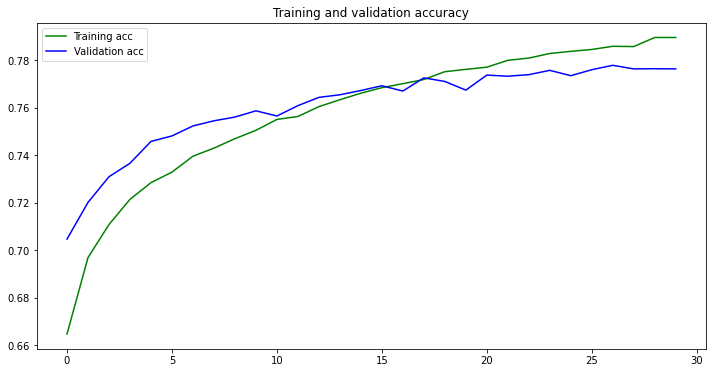

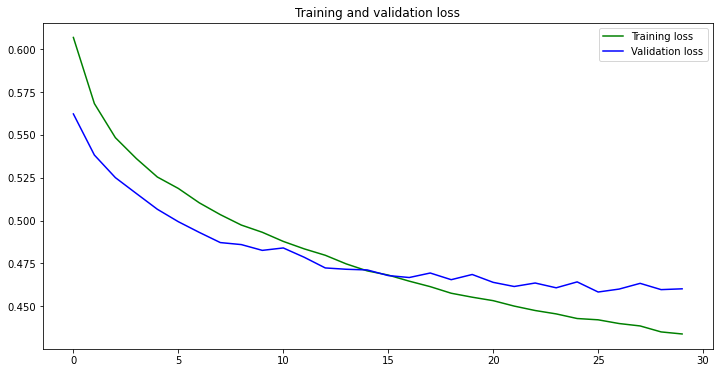

Training Accuracy: 0.8092
Testing Accuracy:  0.8224


In [219]:
acc = training_model.history['acc']
val_acc = training_model.history['val_acc']
loss = training_model.history['loss']
val_loss = training_model.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12,6))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (Exactitude) ')
plt.legend()

plt.figure(figsize=(12,6))


plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (cout) ')
plt.legend()

plt.show()

loss, accuracy = lstm_model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = lstm_model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


In [204]:
# les valeurs de prédiction
y_pred = lstm_model.predict(x_test)  # outputs
# numpy array vide pour observation 
y_pred_array = np.zeros(x_test.shape[0])

# prédire les classes
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convertir en entier
y_pred_array = y_pred_array.astype(int)

In [205]:
y_test_array = np.zeros(x_test.shape[0])

for i in range(0, y_test.shape[0]):
    label_predict = np.argmax(y_test[i])
    y_test_array[i] = label_predict

y_test_array = y_test_array.astype(int)

In [206]:
class_names = np.array(['Negative', 'Positive'])

Matrice de confusion
[[20215  4122]
 [ 4760 20903]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     24337
           1       0.84      0.81      0.82     25663

    accuracy                           0.82     50000
   macro avg       0.82      0.82      0.82     50000
weighted avg       0.82      0.82      0.82     50000

Confusion matrix, without normalization
[[20215  4122]
 [ 4760 20903]]


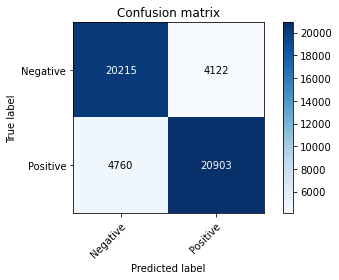

In [257]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

np.set_printoptions(precision=2)

print("Matrice de confusion")
print (confusion_matrix(y_test_array, y_pred_array))
print (classification_report(y_test_array, y_pred_array))

# Plot pour la visualisation confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix')

plt.show()

In [245]:
# enregistrement du modéle
lstm_model.save('./ModelML/modelSA.h5')